In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer

from nltk.translate.bleu_score import sentence_bleu
from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.auc_score import AUCScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
MODELS = {
    "Gemma 1.1 - 2B": "google/gemma-1.1-2b-it",
    "Gemma 1.1 - 7B": "google/gemma-1.1-7b-it",
    "Gemma 2.0 - 9B": "google/gemma-2-9b-it",
    "Llama 3.1 - 8B": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "Llama 3.2 - 1B": "meta-llama/Llama-3.2-1B-Instruct",
    "Llama 3.2 - 3B": "meta-llama/Llama-3.2-3B-Instruct",
    "Falcon 1.0 - 7B": "tiiuae/Falcon-7B-Instruct",
    "Falcon 3.0 - 3B": "tiiuae/Falcon3-3B-Instruct",
    "Falcon 3.0 - 7B": "tiiuae/Falcon3-7B-Instruct",
    "Falcon 3.0 - 10B": "tiiuae/Falcon3-10B-Instruct"
}
LABELS = np.array(['allergens', 'biological', 'foreign bodies', 'chemical', 'organoleptic aspects', 'fraud'], dtype=object)

PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    t_start = time.time()
    with open(f'results/food incidents - hazard/{MODELS[key]}.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)
    print(f'Loaded {key} ({len(RESULTS[key]):d} instances, dt={(time.time()-t_start)*1000:.2f} ms).')

Loaded Gemma 1.1 - 2B (200 instances, dt=976.54 ms).
Loaded Gemma 1.1 - 7B (200 instances, dt=968.85 ms).
Loaded Gemma 2.0 - 9B (200 instances, dt=1132.91 ms).
Loaded Llama 3.1 - 8B (200 instances, dt=942.76 ms).
Loaded Llama 3.2 - 1B (200 instances, dt=918.51 ms).
Loaded Llama 3.2 - 3B (200 instances, dt=965.84 ms).
Loaded Falcon 1.0 - 7B (200 instances, dt=988.01 ms).
Loaded Falcon 3.0 - 3B (200 instances, dt=1002.81 ms).
Loaded Falcon 3.0 - 7B (200 instances, dt=967.46 ms).
Loaded Falcon 3.0 - 10B (200 instances, dt=971.99 ms).


In [4]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, i_sample=8, save_dir=PLOTS_DIR)
plotter = Plotter(RESULTS, save_dir=PLOTS_DIR)
scorer  = AUCScorer(RESULTS)
plotter.print_chat("Llama 3.1 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the reason for the recall of the food product in the following announcement?

"Certain Duke's brand Dry Apple Cider may contain quality/spoilage"

Assign one of the following labels: "biological", "allergens", "chemical", "foreign bodies", "organoleptic aspects", or "fraud". Make sure to answer only with the label or "none" if none of them applies.} \\

&
\textbf{assistant}: &
\texttt{"organoleptic aspects"} \\


\hline

&
\textbf{user}: &
\texttt{What is the most important phrase of the announcement influencing your assessment? Provide only the phrase as a string.} \\

&
\textbf{assistant}: &
\texttt{"quality/spoilage"} \\


\hline

&
\textbf{user}: &
\texttt{Provide a version of the announcement that would alter your assessment to "foreign bodies" while changing as few words in the original announcement as possible.} \\

&
\textbf{assistant}: &
\texttt{"Certain Duke's brand Dry

# Performance:

In [5]:
for model in RESULTS:
    y_true = np.array([''.join(item['label']['tokens']) for item in RESULTS[model]])
    y_pred = np.array([''.join(item['prediction']['text']) for item in RESULTS[model]])

    ls = np.unique(y_true)
    y_true = np.array([y_true == l for l in ls]).T
    y_pred = np.array([y_pred == l for l in ls]).T
    
    print(model)
    print(f'  F1:           {f1_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  precision:    {precision_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  recall:       {recall_score(y_true, y_pred, average="macro"):.2f}')
    print()

Gemma 1.1 - 2B
  F1:           0.28
  precision:    0.42
  recall:       0.22

Gemma 1.1 - 7B
  F1:           0.48
  precision:    0.61
  recall:       0.48

Gemma 2.0 - 9B
  F1:           0.53
  precision:    0.63
  recall:       0.51

Llama 3.1 - 8B
  F1:           0.44
  precision:    0.43
  recall:       0.45

Llama 3.2 - 1B
  F1:           0.02
  precision:    0.18
  recall:       0.01

Llama 3.2 - 3B
  F1:           0.17
  precision:    0.46
  recall:       0.12

Falcon 1.0 - 7B
  F1:           0.05
  precision:    0.12
  recall:       0.03

Falcon 3.0 - 3B
  F1:           0.23
  precision:    0.43
  recall:       0.17

Falcon 3.0 - 7B
  F1:           0.45
  precision:    0.60
  recall:       0.44

Falcon 3.0 - 10B
  F1:           0.47
  precision:    0.60
  recall:       0.46



/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/

# Faithfullness:

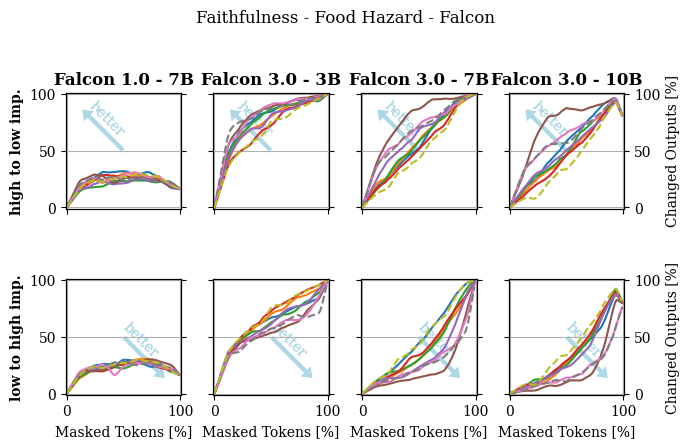

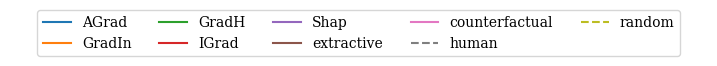

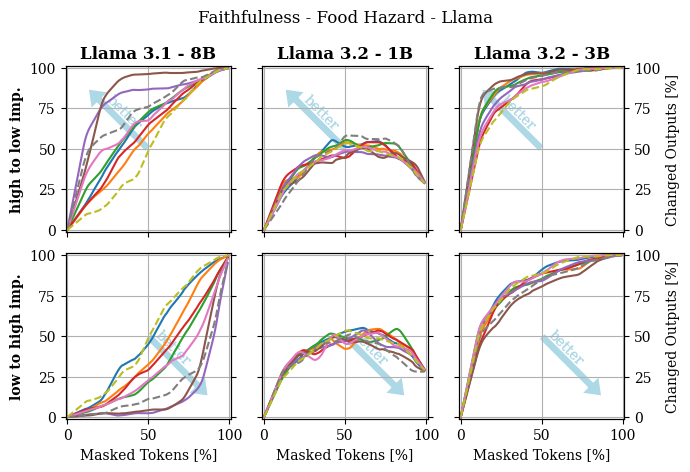

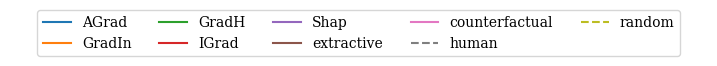

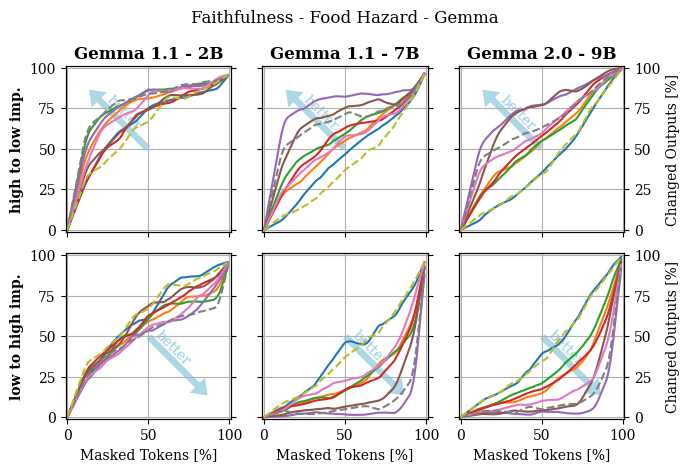

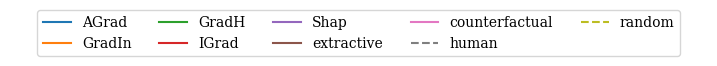

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & Gemma 1.1 - 2B & Gemma 1.1 - 7B & Gemma 2.0 - 9B & Llama 3.1 - 8B & Llama 3.2 - 1B & Llama 3.2 - 3B & Falcon 1.0 - 7B & Falcon 3.0 - 3B & Falcon 3.0 - 7B & Falcon 3.0 - 10B \\
\midrule
AGrad & 0.04 & 0.05 & -0.01 & 0.13 & -0.00 & 0.06 & 0.02 & 0.16 & 0.08 & 0.21 \\
GradIn & 0.19 & 0.28 & 0.29 & 0.15 & 0.01 & 0.10 & 0.01 & 0.09 & 0.18 & 0.14 \\
GradH & 0.22 & 0.34 & 0.24 & 0.32 & 0.01 & 0.08 & -0.01 & 0.15 & 0.16 & 0.16 \\
IGrad & 0.08 & 0.33 & 0.32 & 0.22 & 0.00 & 0.04 & 0.01 & 0.02 & 0.12 & 0.10 \\
Shap & 0.25 & 0.69 & 0.65 & 0.66 & 0.00 & 0.05 & -0.02 & 0.12 & 0.29 & 0.17 \\
human & 0.28 & 0.55 & 0.52 & 0.53 & 0.04 & 0.12 & -0.00 & 0.27 & 0.40 & 0.40 \\
extractive & 0.07 & 0.53 & 0.56 & 0.66 & 0.01 & 0.16 & 0.00 & 0.26 & 0.53 & 0.53 \\
counterfactual & 0.20 & 0.25 & 0.44 & 0.37 & -0.01 & 0.01 & 0.02 & 0.24 & 0.38 & 0.41 \\
\bottomrule
\end{tabular}



In [6]:
plotter.plot_perturbation('Faithfulness - Food Hazard')
print(scorer.score_table().to_latex(formatters={"name": str.upper},  float_format="{:.2f}".format))

Gemma 1.1 - 2B

In [7]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 2B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['the reason for the recall is not specified in the', '1600']],
      dtype='<U49')

Gemma 1.1 - 7B

In [8]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['foreign bodies', '208'],
       ['foreign bodies<eos>', '200'],
       ['the provided text is not included in the prompt,', '1192']],
      dtype='<U48')

Gemma 2.0 - 9B

In [9]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 2.0 - 9B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['please provide the announcement so i can determine the reason',
        '1600']], dtype='<U61')

Llama 3.1 - 8B

In [10]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.1 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I'm happy to help you with this problem!", '8'],
       ["I'm happy to help! However, I don", '352'],
       ["I'm not able to read the announcement you provided", '296'],
       ["I'm not able to view the announcement you're", '768'],
       ["I'm ready to help. Please go ahead and", '56'],
       ["I'm sorry, but I am unable to process", '112'],
       ['There is no announcement provided. Please provide the announcement',
        '8']], dtype='<U66')

Llama 3.2 - 1B

In [11]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 1B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['biological<|eot_id|>', '120'],
       ['none<|eot_id|>', '1480']], dtype='<U21')

Llama 3.2 - 3B

In [12]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 3B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I can't provide a response with only a number", '16'],
       ["I don't see an announcement provided. Please share", '368'],
       ["I'm ready to help. However, I don", '56'],
       ["I'm ready to help. What is the announcement", '1160']],
      dtype='<U50')

Falcon 1.0 - 7B

In [13]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 1.0 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['"None"\nUser <|endoftext|>', '1592'],
       ['"None"<|endoftext|>', '8']], dtype='<U25')

Falcon 3.0 - 3B

In [14]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 3.0 - 3B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I'm sorry, but I cannot access or", '8'],
       ["I'm sorry, but I cannot provide the", '232'],
       ["I'm sorry, but I need the full", '24'],
       ["I'm sorry, but the announcement excerpt provided", '32'],
       ['The announcement does not provide enough information to determine the',
        '8'],
       ['The announcement for the food product recall is due to', '8'],
       ['The announcement for the recall of the food product is', '1248'],
       ['The label for the reason of the food product recall', '8'],
       ['none<|endoftext|>', '32']], dtype='<U69')

Falcon 3.0 - 7B

In [15]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 3.0 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['To provide an accurate label, I would need the', '24'],
       ['none<|endoftext|>', '1576']], dtype='<U46')

Falcon 3.0 - 10B

In [16]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Falcon 3.0 - 10B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['"biological"<|endoftext|>', '96'],
       ['None<|endoftext|>', '8'],
       ['biological<|endoftext|>', '816'],
       ['none<|endoftext|>', '680']], dtype='<U25')

# Self assessment:

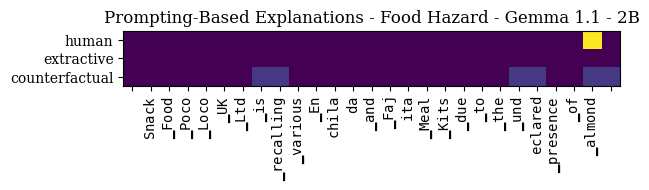

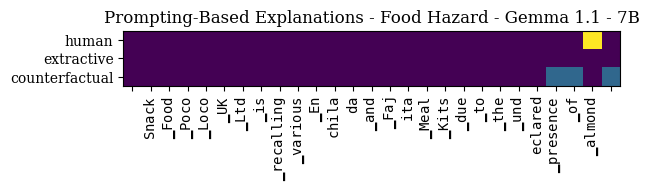

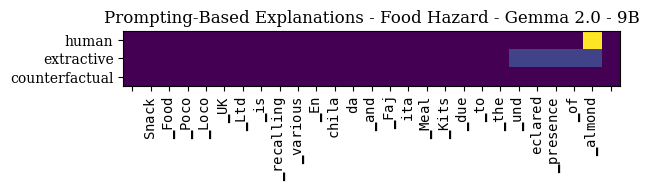

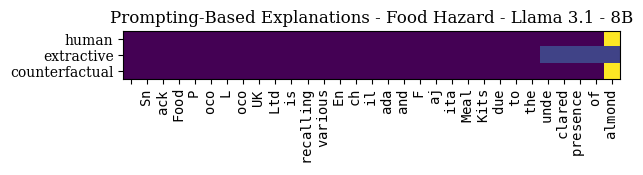

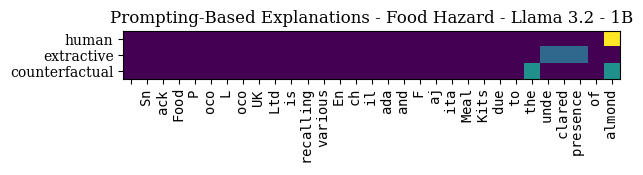

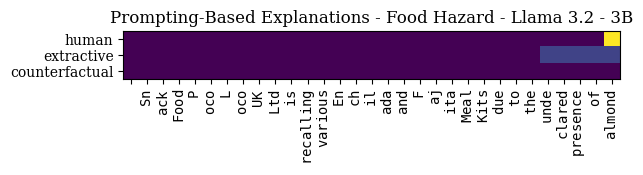

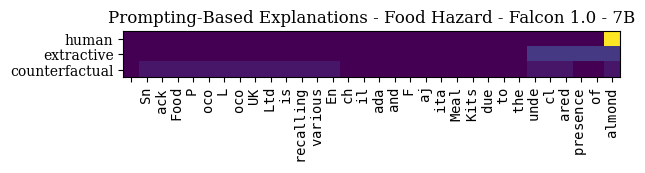

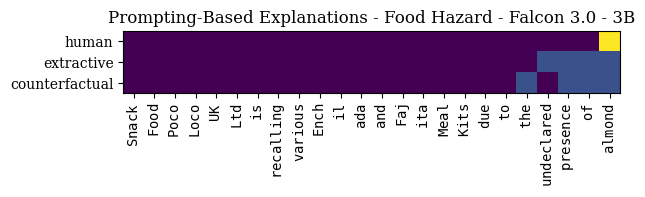

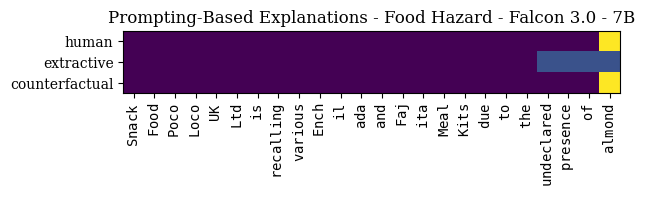

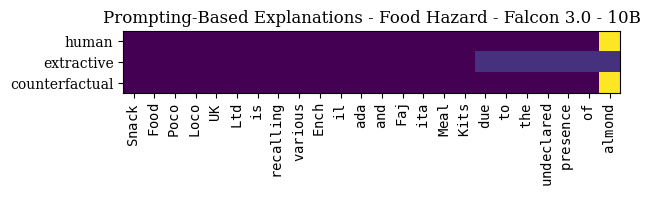

In [17]:
importance_human = {model:[] for model in RESULTS}
importance_self  = {model:[] for model in RESULTS}
importance_cf    = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']
        
        importance_human[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['human']: 
            importance_human[model][-1][i-offset:j-offset] = 1.
        importance_human[model][-1] /= max(importance_human[model][-1].sum(), 1e-9)
        
        importance_self[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['extractive'][:len(r['spans']['human'])]:
            importance_self[model][-1][i-offset:j-offset] = 1.
        importance_self[model][-1] /= max(importance_self[model][-1].sum(), 1e-9)
        
        importance_cf[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['counterfactual']:
            importance_cf[model][-1][i-offset:j-offset] = 1.
        importance_cf[model][-1] /= max(importance_cf[model][-1].sum(), 1e-9)

plotter.plot_importance([importance_human, importance_self, importance_cf], ['human', 'extractive', 'counterfactual'], f'Prompting-Based Explanations - Food Hazard')
pearson.add(importance_human, 'human')
pearson.add(importance_self,  'extractive')
pearson.add(importance_cf,    'counterfactual')

# AGrad:

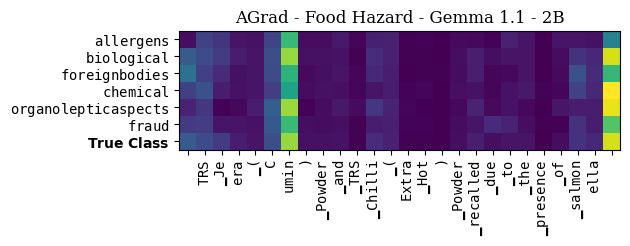

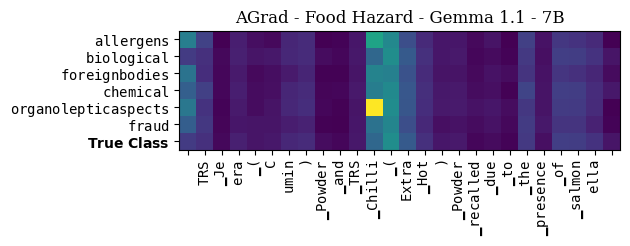

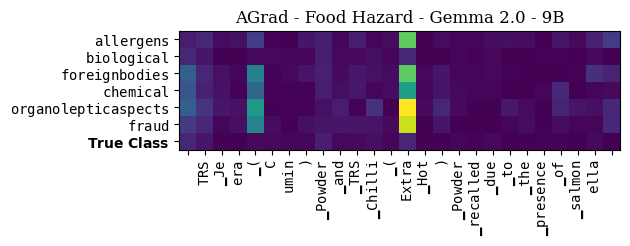

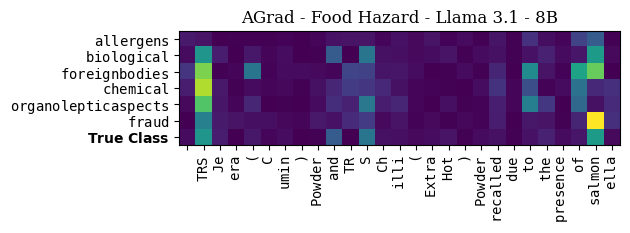

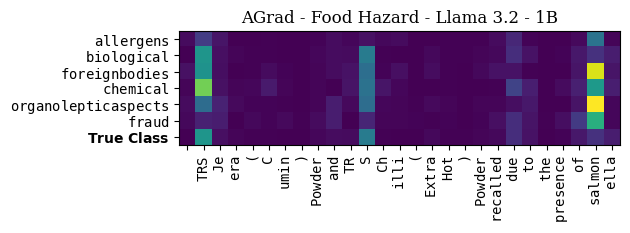

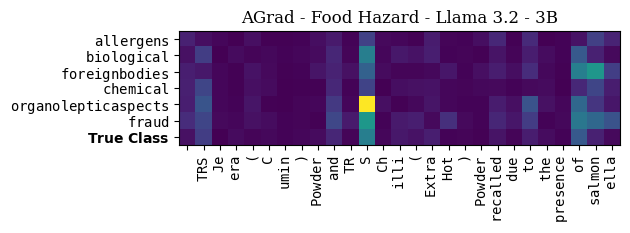

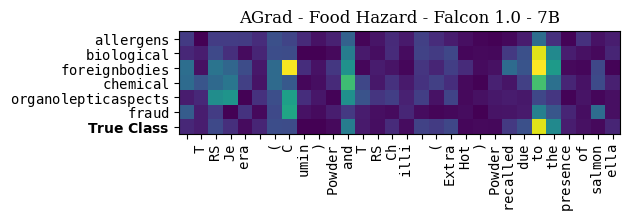

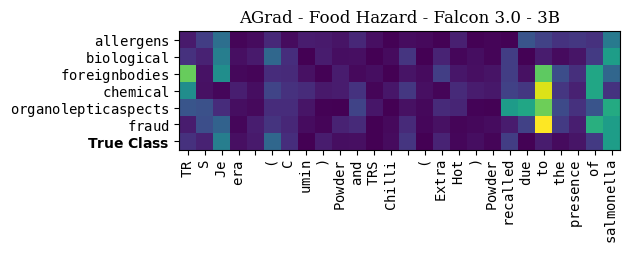

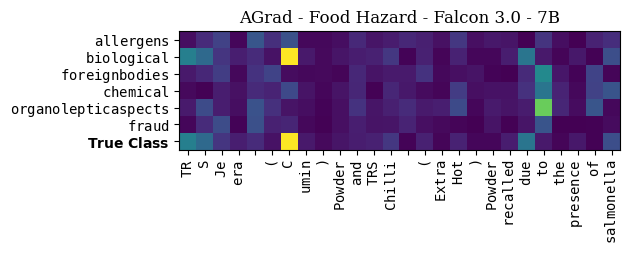

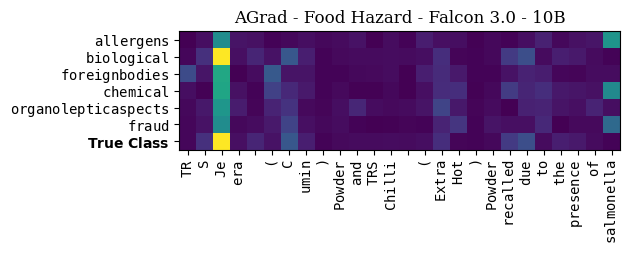

In [18]:
importance_agrad_raw = {model:[] for model in RESULTS}
importance_agrad_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get importance:
        importance = np.abs(r['AGrad'][:, :, x_start:x_end].mean(axis=0))

        # per token in label:
        importance_agrad_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_agrad_cls[model].append(importance_agrad_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_agrad_raw, importance_agrad_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'AGrad - Food Hazard')
pearson.add(importance_agrad_cls, 'AGrad')

# GradIn

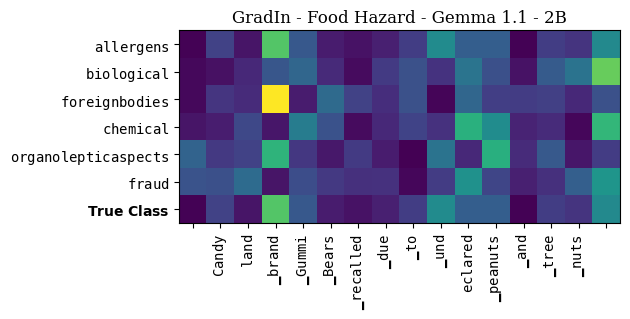

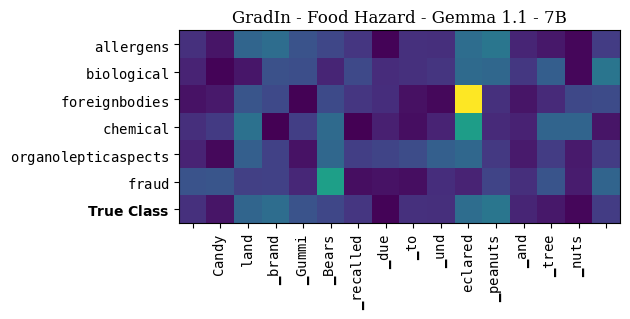

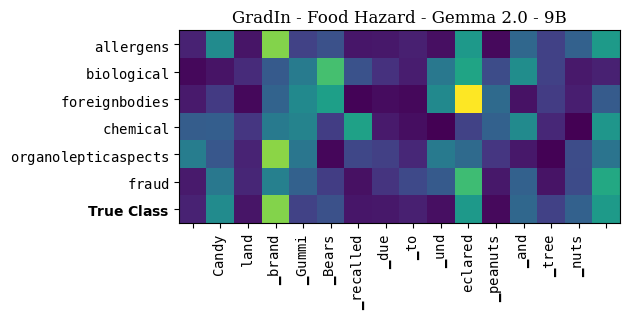

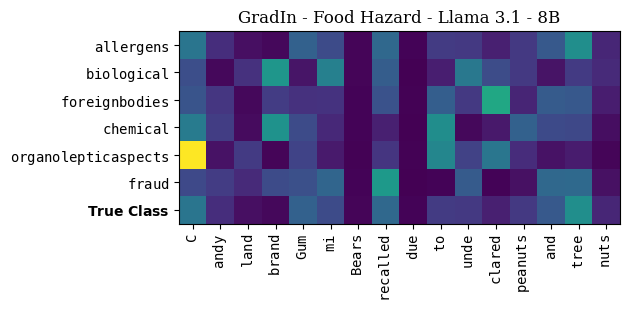

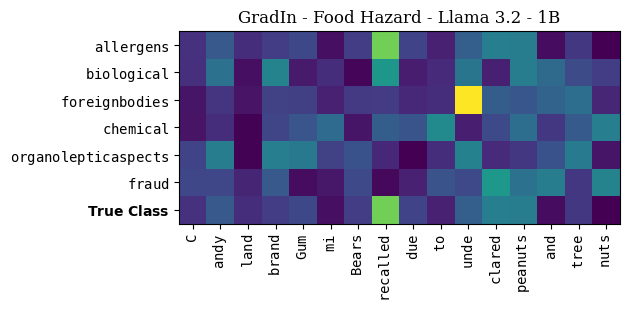

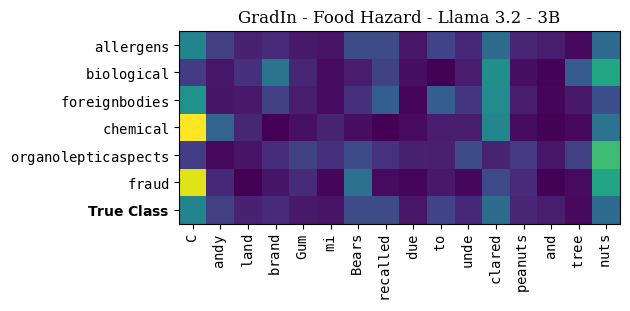

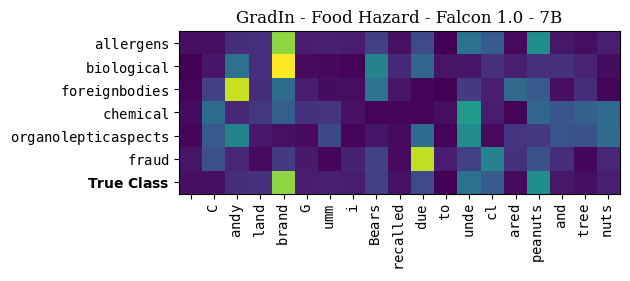

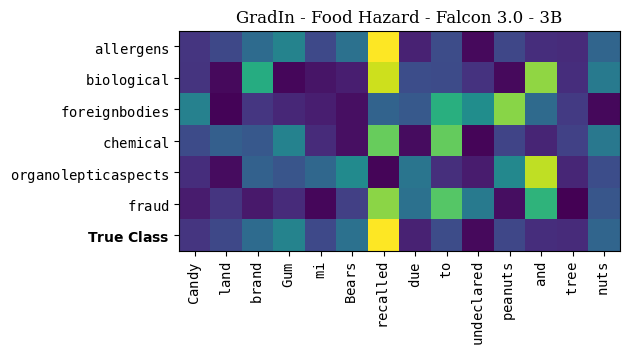

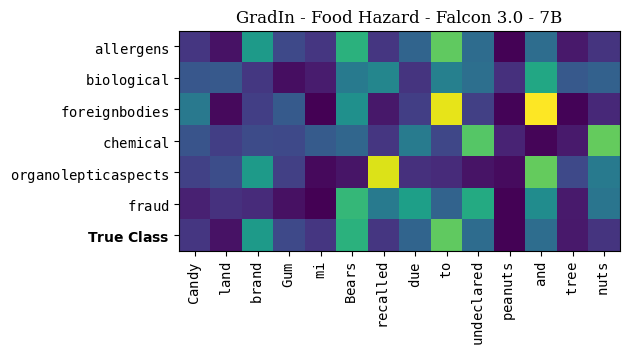

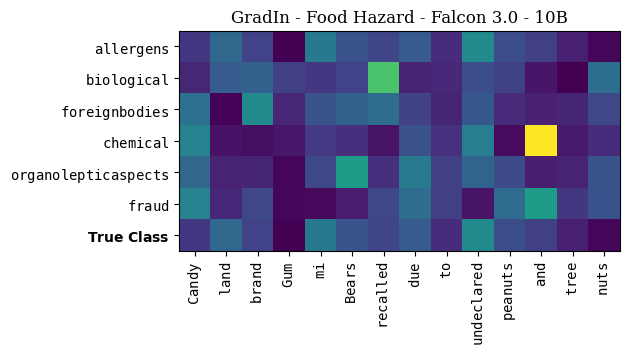

In [19]:
importance_gradin_raw = {model:[] for model in RESULTS}
importance_gradin_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradIn'][:, start:end])
    
        # per token in label:
        importance_gradin_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_gradin_cls[model].append(importance_gradin_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_gradin_raw, importance_gradin_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'GradIn - Food Hazard')
pearson.add(importance_gradin_cls, 'GradIn')

# GradH

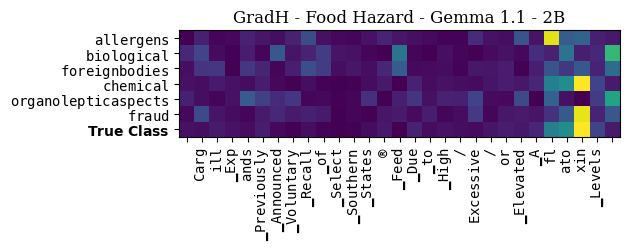

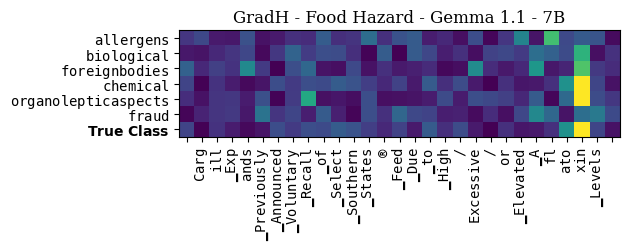

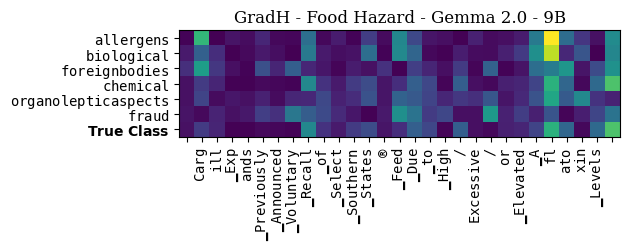

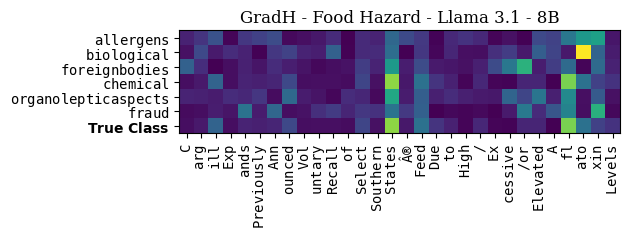

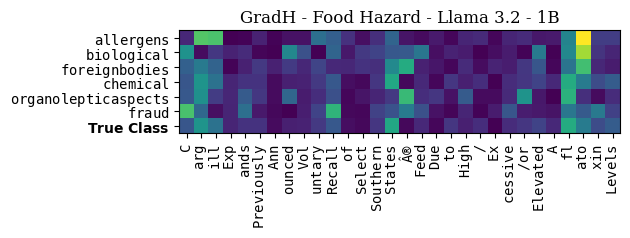

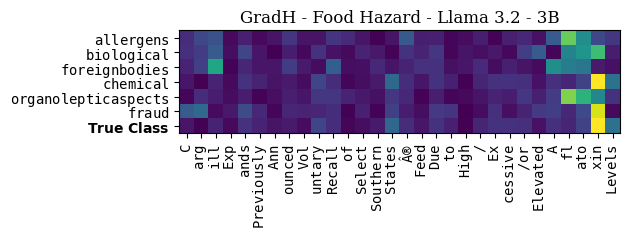

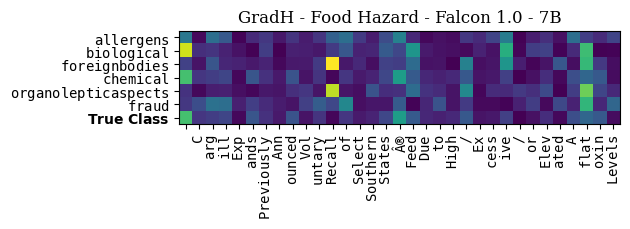

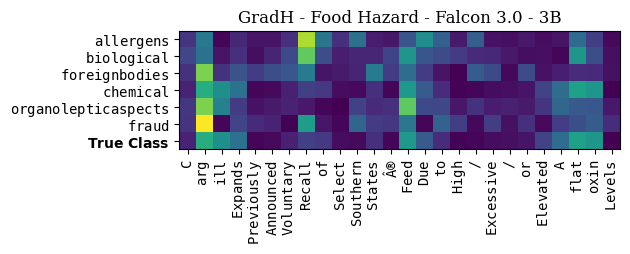

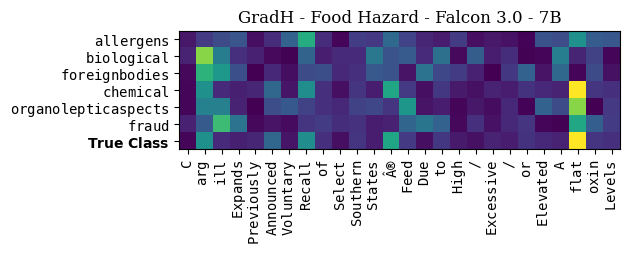

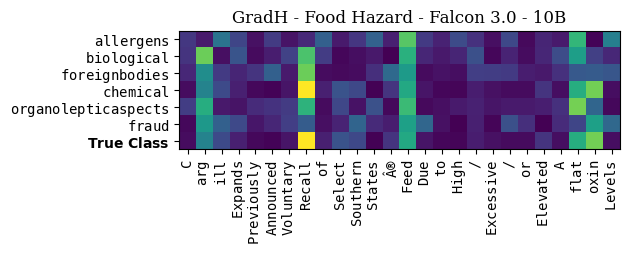

In [20]:
importance_gradh_raw = {model:[] for model in RESULTS}
importance_gradh_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradH'][:, start:end])
    
        # per token in label:
        importance_gradh_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_gradh_cls[model].append(importance_gradh_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_gradh_raw, importance_gradh_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'GradH - Food Hazard')
pearson.add(importance_gradh_cls, 'GradH')

# Grad$^{-1}$

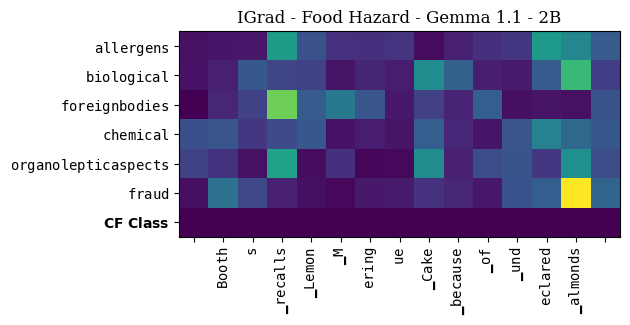

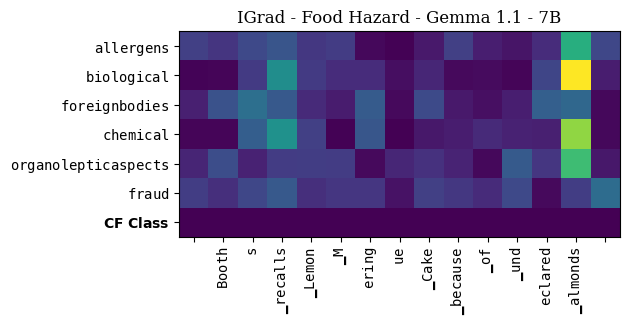

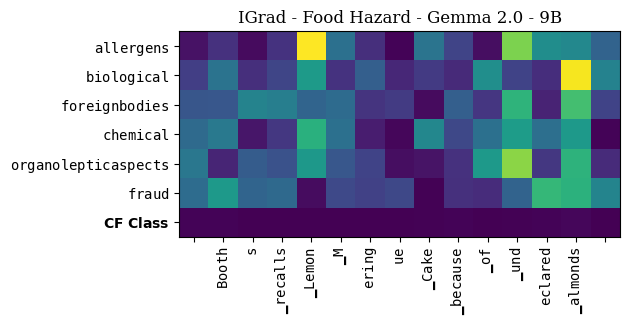

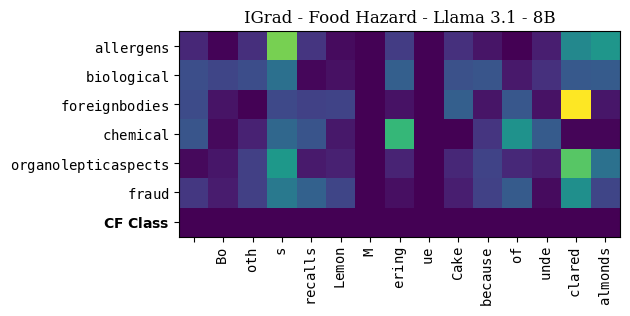

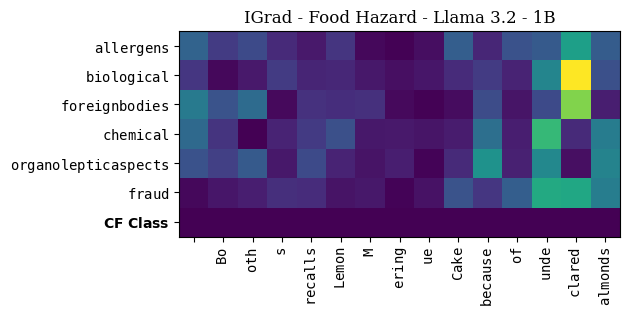

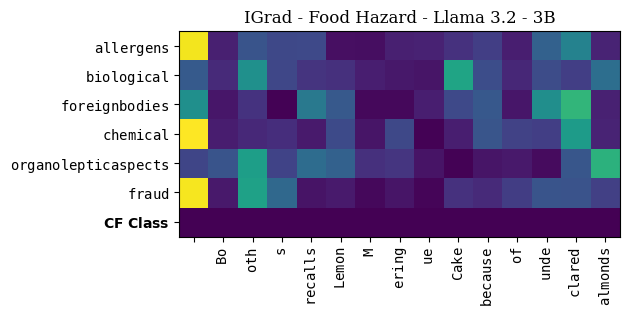

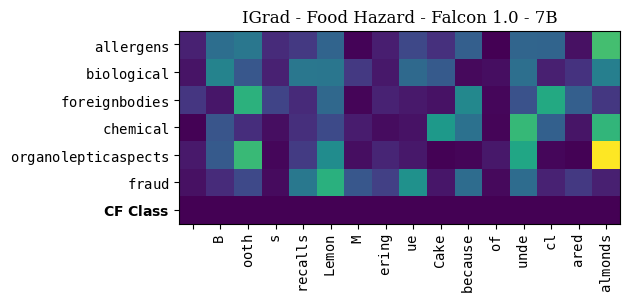

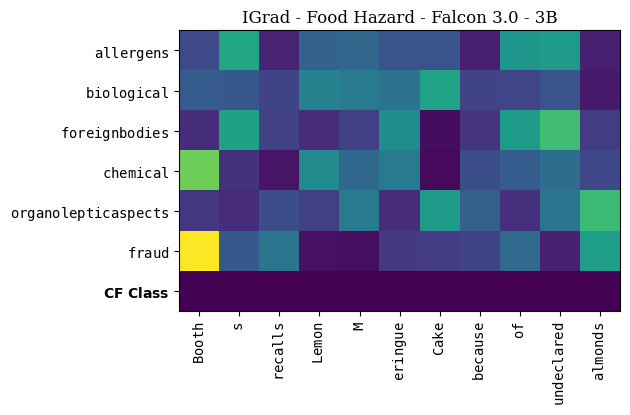

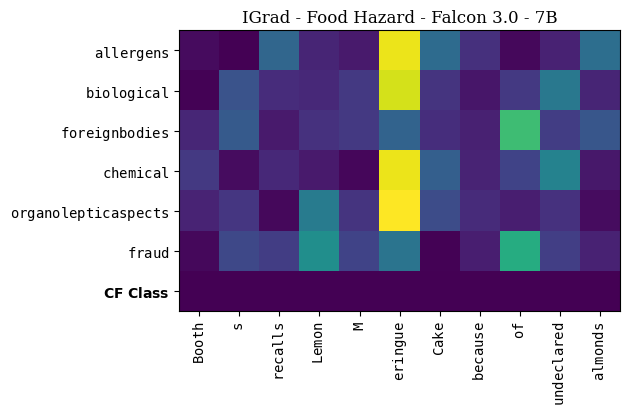

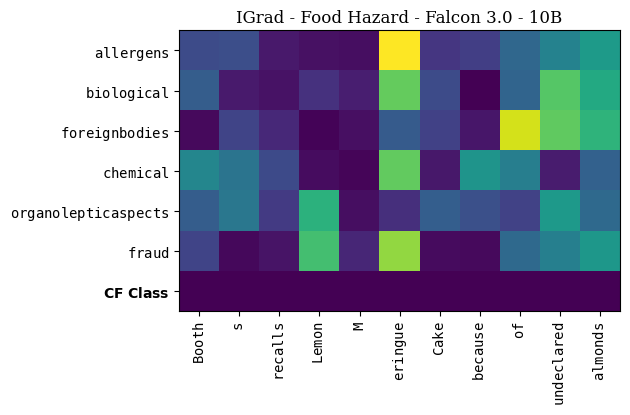

In [21]:
importance_igrad_raw = {model:[] for model in RESULTS}
importance_igrad_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get counterfactual label:
        cf    = r['counterfactual']['target_label']

        # get importance:
        importance = np.abs(r['IGrad'][:,start:end,:].mean(axis=-1))

        importance_igrad_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only counterfactual class:
        importance_igrad_cls[model].append(importance_igrad_raw[model][-1][cf])

#        # create counterfactual text:
#        original = np.zeros(importance.shape[1:], dtype=float)
#        for i, token in enumerate(r['tokens'][start:end]):
#            original[i, r['IGrad-tokens'][:1024].index(token)] = 1.
#
#        print(r['prediction']['text'], '->', cf, [r['IGrad-tokens'][i] for i in (original - importance[LABELS == cf][0]).argmax(axis=-1)])

plotter.plot_importance([importance_gradin_raw, importance_igrad_cls], ['', '$\\bf\u007bCF~Class\u007d$'], f'IGrad - Food Hazard')
pearson.add(importance_igrad_cls, 'IGrad')

# Shap:

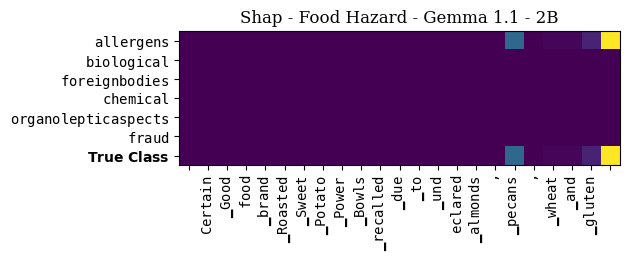

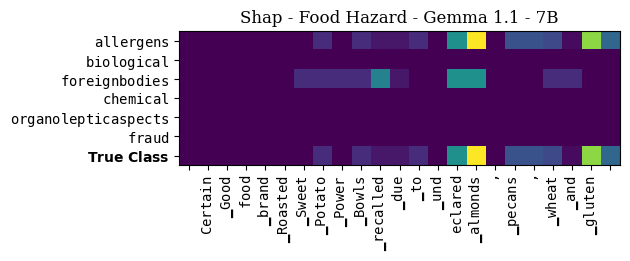

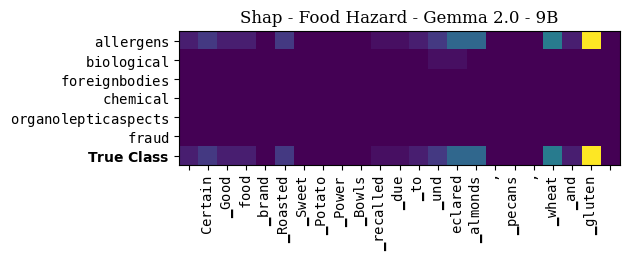

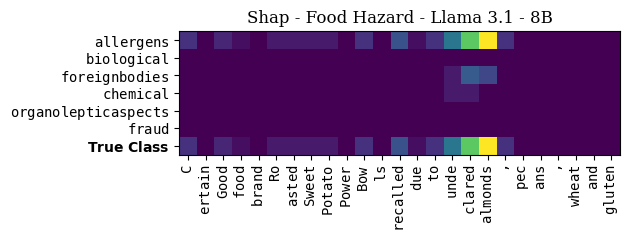

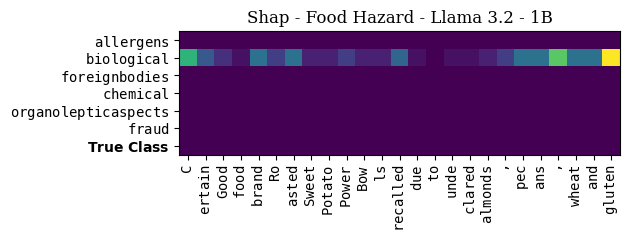

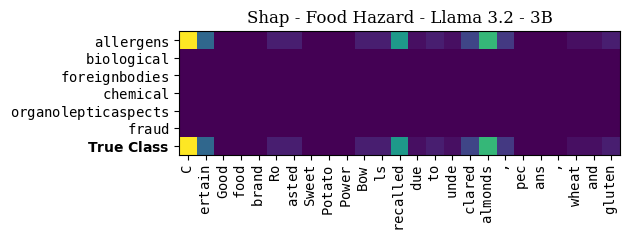

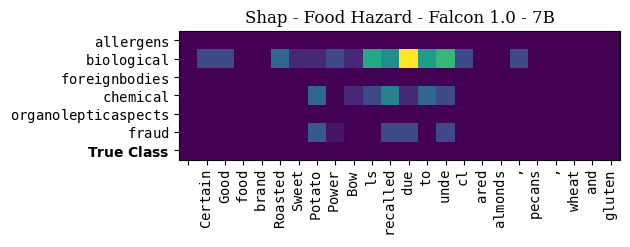

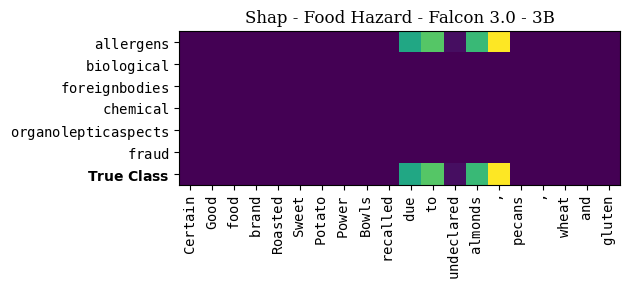

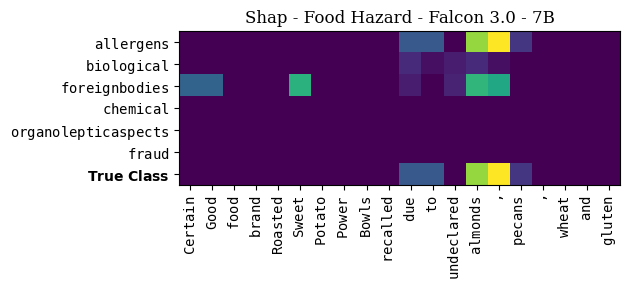

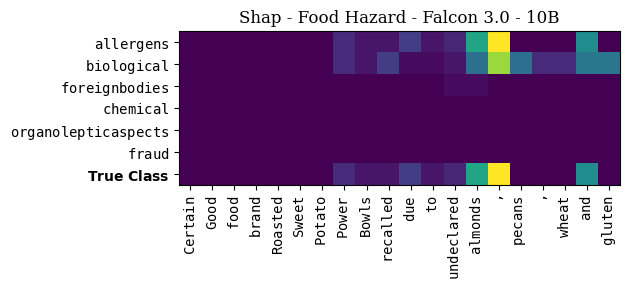

In [22]:
importance_shap_cls = {model:[] for model in RESULTS}
importance_shap_raw = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        if not 'Shap' in r: continue

        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get importance:
        importance = np.abs(r['Shap'][:, start:end])

        # per token in label:
        importance_shap_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_shap_cls[model].append(importance_shap_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_shap_raw, importance_shap_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'Shap - Food Hazard')
pearson.add(importance_shap_cls, 'Shap')

/tmp/ipykernel_4039623/2557847837.py:1: RuntimeWarning: invalid value encountered in divide
  scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}


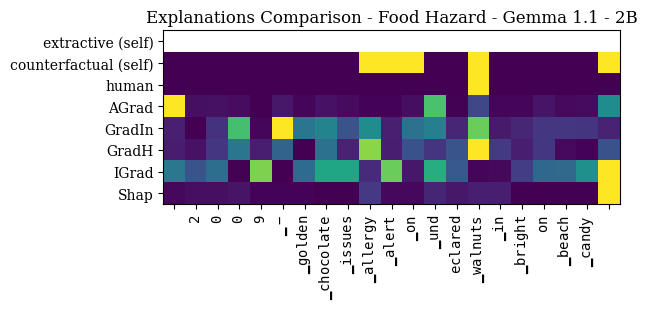

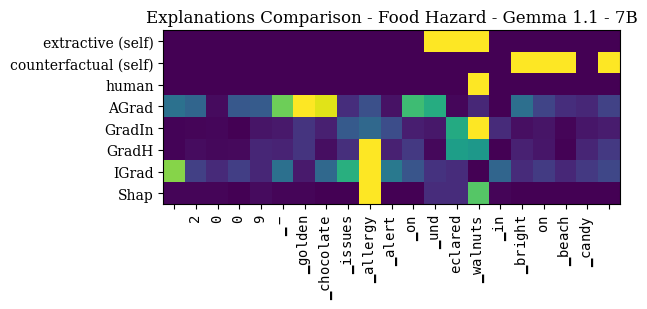

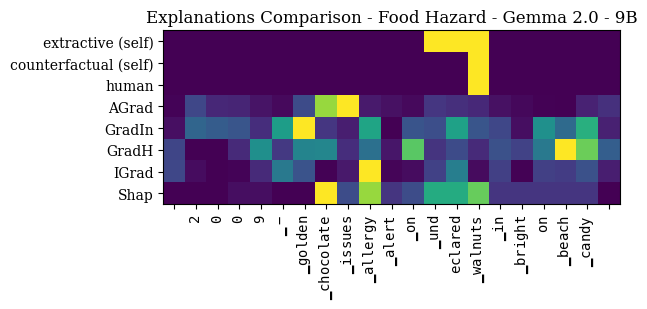

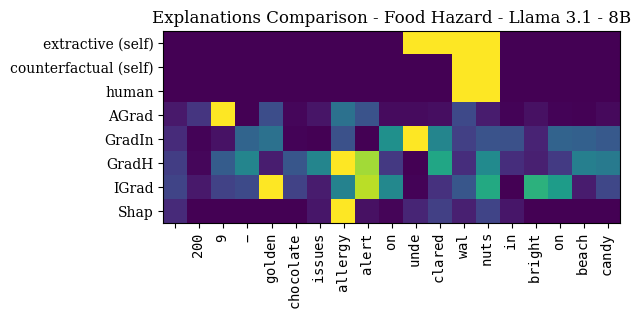

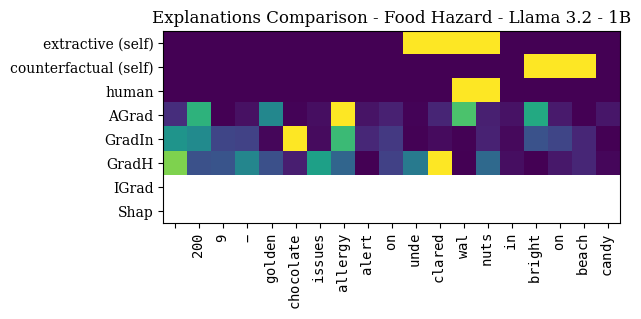

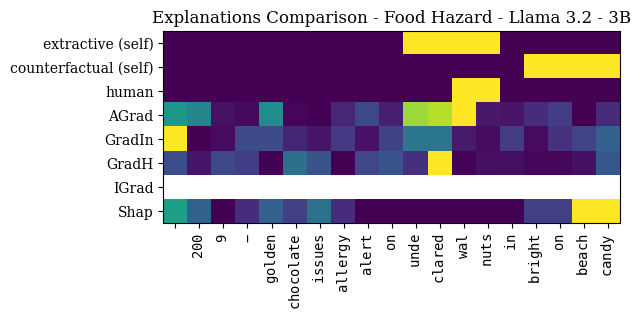

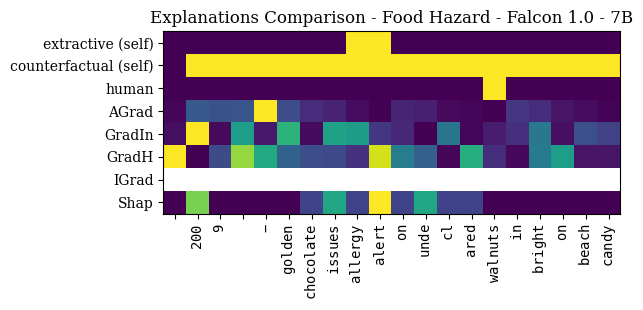

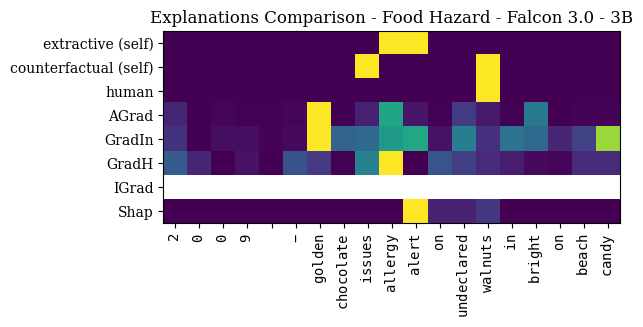

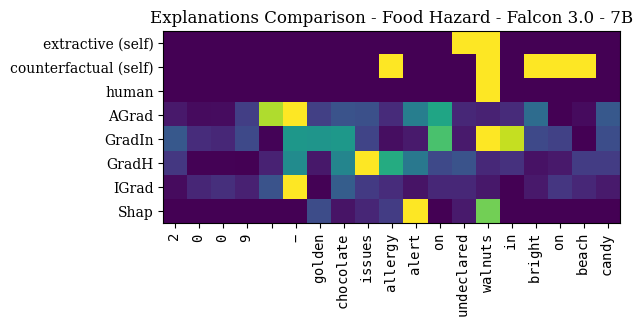

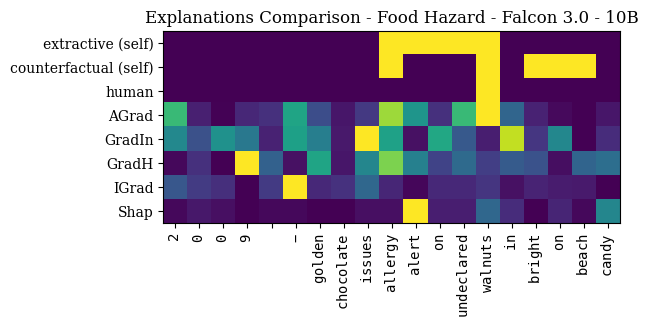

In [23]:
scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}
plotter.plot_importance(
    [
        scale(importance_self),
        scale(importance_cf),
        scale(importance_human),
        scale(importance_agrad_cls),
        scale(importance_gradin_cls),
        scale(importance_gradh_cls),
        scale(importance_igrad_cls),
        scale(importance_shap_cls)
    ],
    ['extractive (self)', 'counterfactual (self)', 'human', 'AGrad', 'GradIn', 'GradH', 'IGrad', 'Shap'],
    f'Explanations Comparison - Food Hazard'
)

# Correlations:

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


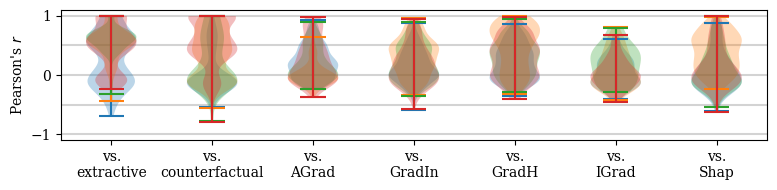

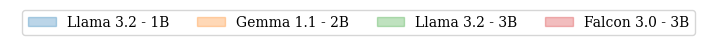

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


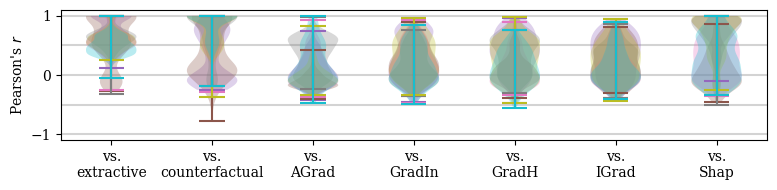

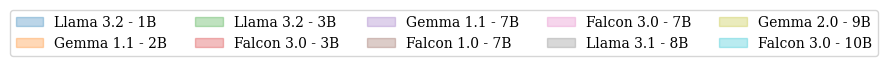

In [24]:
pearson.boxplot('human', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Human.pdf')

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


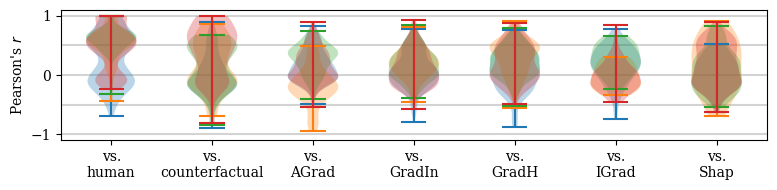

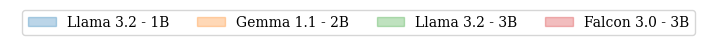

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


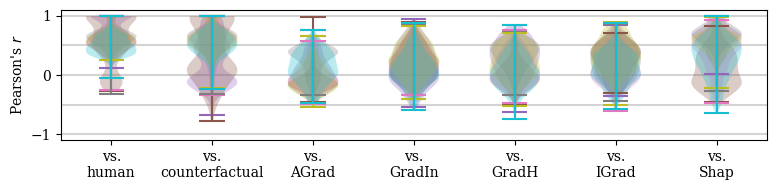

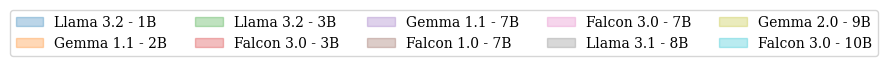

In [25]:
pearson.boxplot('extractive', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Self.pdf')

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


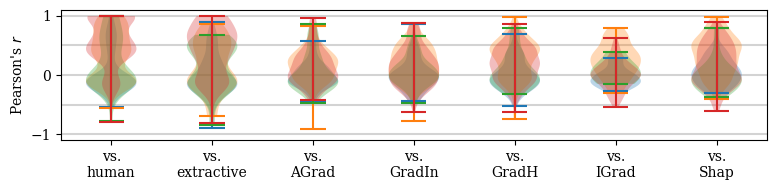

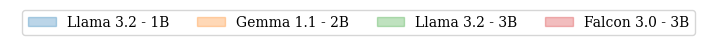

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


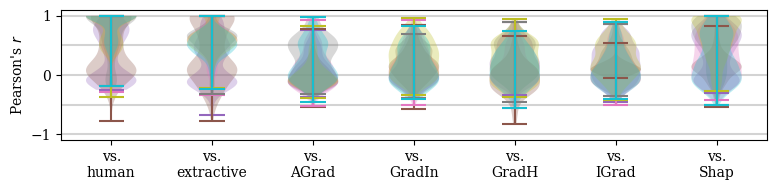

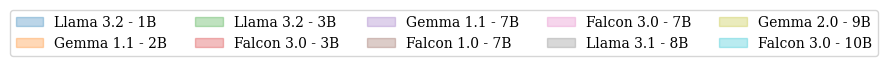

In [26]:
pearson.boxplot('counterfactual', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Counterfactual.pdf')

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


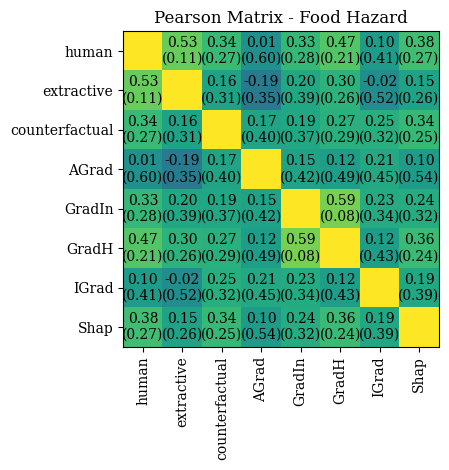

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


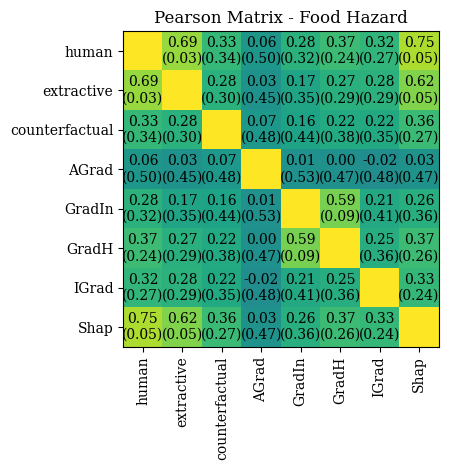

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


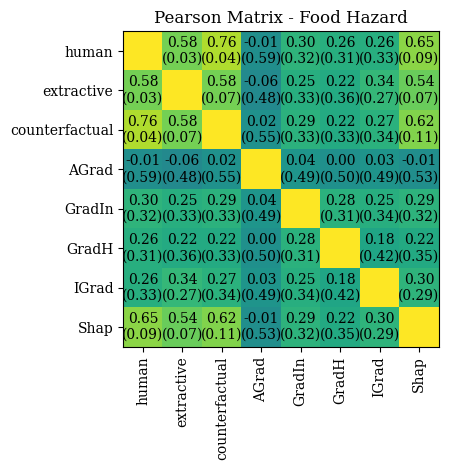

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


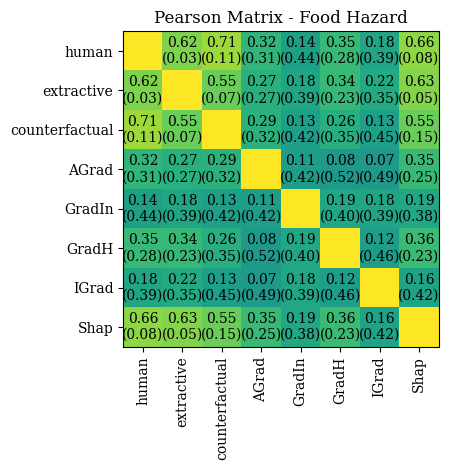

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


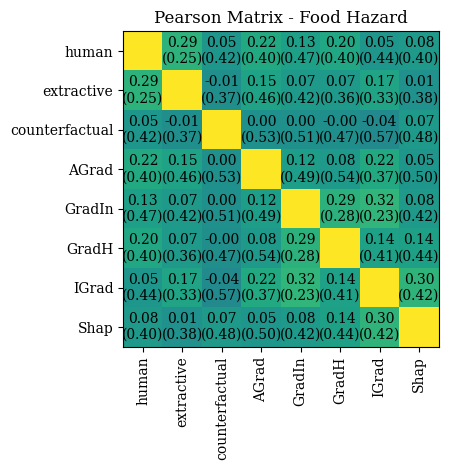

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


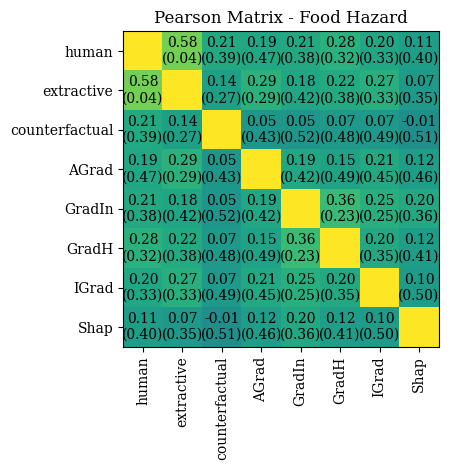

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


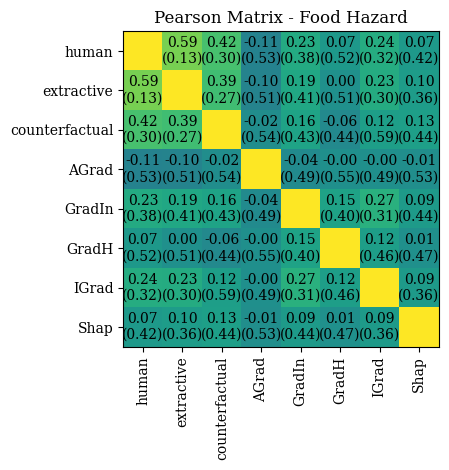

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


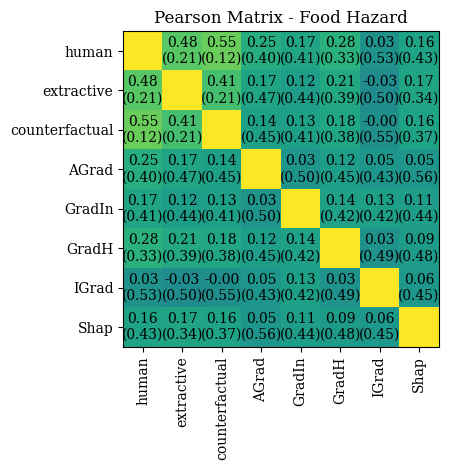

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


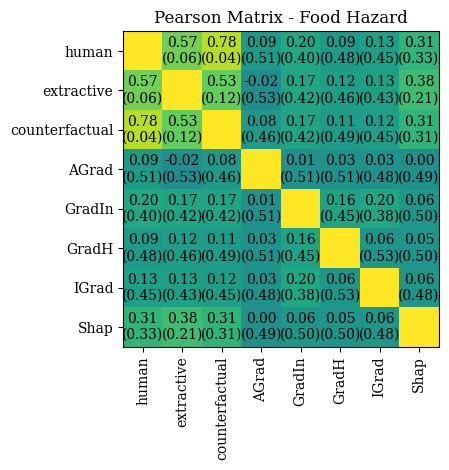

/home/h21/kora8563/explainability/resources/testing.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


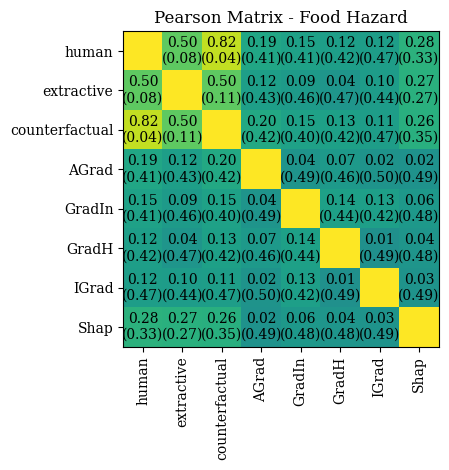

In [27]:
pearson.matrixplot(title='Pearson Matrix - Food Hazard', dir=PLOTS_DIR)

# Counterfactual:

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Gemma 1.1 - 2B
  Success rate: 0.94
  Similarity: 0.9447556602282727
  BLEU: 0.691506715000356
  ROUGE-1: 0.5469772005247447
  ROUGE-L: 0.6895564582496914
  BART: -2.429511400930425

Gemma 1.1 - 7B
  Success rate: 1.0
  Similarity: 0.9580952373876366
  BLEU: 0.785001861664773
  ROUGE-1: 0.6651072716021339
  ROUGE-L: 0.7834830495600539
  BART: -2.1162849034368993

Gemma 2.0 - 9B
  Success rate: 1.0
  Similarity: 0.9582643595352336
  BLEU: 0.7494387393796774
  ROUGE-1: 0.6507186115992413
  ROUGE-L: 0.7494387393796774
  BART: -3.7424407345056534

Llama 3.1 - 8B
  Success rate: 0.945
  Similarity: 0.9203140782400467
  BLEU: 0.7012315257315286
  ROUGE-1: 0.5484369590857866
  ROUGE-L: 0.6797634535500908
  BART: -3.0467052220036743

Llama 3.2 - 1B
  Success rate: 0.265
  Similarity: 0.9118241568577272
  BLEU: 0.6409578560544077
  ROUGE-1: 0.4013025896181057
  ROUGE-L: 0.5927938550113298
  BART: -2.923720730925506

Llama 3.2 - 3B
  Success rate: 0.915
  Similarity: 0.8416912469370174
  BLEU: 0

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Falcon 1.0 - 7B
  Success rate: 1.0
  Similarity: 0.9391163107015896
  BLEU: 0.6226242608957356
  ROUGE-1: 0.5253284092833872
  ROUGE-L: 0.6133702496923629
  BART: -3.4096472188830376

Falcon 3.0 - 3B
  Success rate: 0.845
  Similarity: 0.9607133886498322
  BLEU: 0.7862851362692016
  ROUGE-1: 0.6413405049325168
  ROUGE-L: 0.7791505004285552
  BART: -2.397861769213479

Falcon 3.0 - 7B
  Success rate: 0.975
  Similarity: 0.9661064573490552
  BLEU: 0.8394346486484013
  ROUGE-1: 0.7345454565825977
  ROUGE-L: 0.839157448371201
  BART: -2.2588696553156926

Falcon 3.0 - 10B
  Success rate: 0.94
  Similarity: 0.9732430580237192
  BLEU: 0.8597499773869204
  ROUGE-1: 0.7699243041365432
  ROUGE-L: 0.8597499773869204
  BART: -2.437945588472042



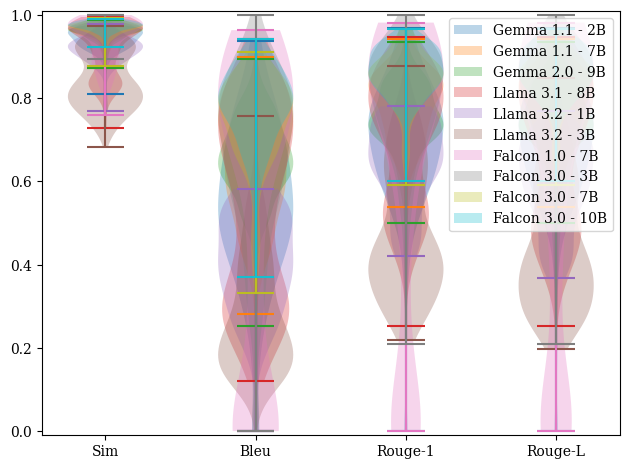

In [28]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

hs, ls = [], [] 
for model in RESULTS:
    counterfactuals = []

    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']

        bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(cf['text'].lower()))
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)

        counterfactuals.append((
            int(success),
            cf['similarity'],
            bleu,                      # bleu
            rouge['rouge1'].fmeasure,  # rouge
            rouge['rougeL'].fmeasure,
            bart[0]
        ))

    counterfactuals = np.array(counterfactuals, dtype=float)

    hs.append(plt.violinplot(counterfactuals[counterfactuals[:,0] == 1., 1:-1])['bodies'][0])
    ls.append(model)

    print(model)
    print('  Success rate:', counterfactuals[:,0].mean())
    print('  Similarity:', counterfactuals[counterfactuals[:,0] == 1., 1].mean())
    print('  BLEU:', counterfactuals[counterfactuals[:,0] == 1., 3].mean())
    print('  ROUGE-1:', counterfactuals[counterfactuals[:,0] == 1., 2].mean())
    print('  ROUGE-L:', counterfactuals[counterfactuals[:,0] == 1., 4].mean())
    print('  BART:', counterfactuals[counterfactuals[:,0] == 1., 5].mean())
    print()

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4], labels=['Sim', 'Bleu', 'Rouge-1', 'Rouge-L'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

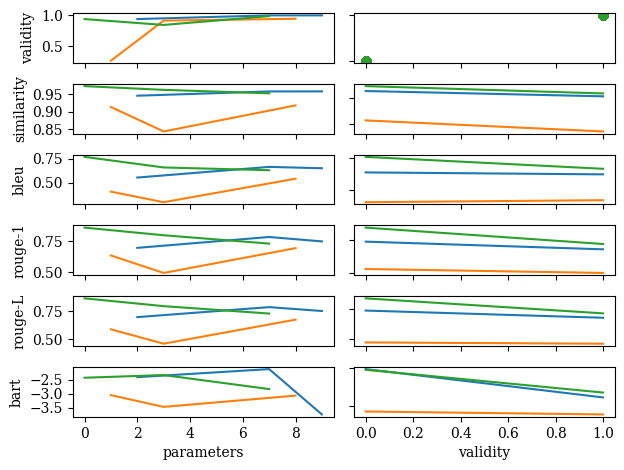

In [29]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

counterfactuals = []
for model in RESULTS:
    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']

        bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(cf['text'].lower()))
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)

        counterfactuals.append({
            'type':       model.split()[0].lower(),
            'parameters': int(model[-2]),
#            'depth':      r['hidden_states'].shape[1],
            'validity':   int(success),
            'similarity': cf['similarity'],
            'bleu':       bleu,
            'rouge-1':    rouge['rouge1'].fmeasure,
            'rouge-L':    rouge['rougeL'].fmeasure,
            'bart':       bart[0]
        })

counterfactuals = pd.DataFrame(counterfactuals)
columns_x = ['parameters', 'validity']
columns_y = ['validity', 'similarity', 'bleu', 'rouge-1', 'rouge-L', 'bart']

fig, axs = plt.subplots(len(columns_y), len(columns_x))
for i, x in enumerate(columns_x):
    for j, y in enumerate(columns_y):
        for tp in counterfactuals['type'].unique():
            values = counterfactuals[counterfactuals['type']==tp][[x, y]]

            if x != y:
                values = values.groupby(x).mean()
                axs[j,i].plot(values.index, values.values, label=tp)

            else: axs[j,i].scatter(values[x].values, values[y].values, label=tp)

        if j == len(columns_y)-1: axs[j,i].set_xlabel(x)
        else: axs[j,i].set_xticklabels([])

        if i == 0: axs[j,i].set_ylabel(y)
        else: axs[j,i].set_yticklabels([])

fig.tight_layout()
fig.show()